In [3]:
!pip uninstall imgaug --yes
!pip install imgaug==0.2.5
!pip install nfts
!pip install stumpy
!pip install statsmodels --upgrade
!pip install dtw-python
!pip install transformers
!pip install backports-datetime-fromisoformat

Found existing installation: imgaug 0.2.5
Uninstalling imgaug-0.2.5:
  Successfully uninstalled imgaug-0.2.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imgaug-0.2.5-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
from datetime import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
import matplotlib.pyplot as plt
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nfts.dataset
import stumpy

from scipy import stats

import torch
from tqdm import tqdm

%matplotlib inline
sns.set(color_codes=True)

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

from datetime import date, datetime, time
from backports.datetime_fromisoformat import MonkeyPatch
MonkeyPatch.patch_fromisoformat()
import datetime as dt

INFO:numba.cuda.cudadrv.driver:init


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/NFT/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Tweets and trades data

### Tweets

In [10]:
df_april = pd.read_csv(DATA_PATH + 'april.csv')
df_may = pd.read_csv(DATA_PATH + 'may.csv')
df_june = pd.read_csv(DATA_PATH + 'june.csv')
df_july = pd.read_csv(DATA_PATH + 'july.csv')
df_august = pd.read_csv(DATA_PATH + 'august.csv')
df_sep = pd.read_csv(DATA_PATH + 'september.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,4,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
frame = [df_april, df_may, df_june, df_july, df_august, df_sep]
df = pd.concat(frame)
df = df.drop_duplicates()

In [12]:
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True) 

In [13]:
bins = sorted(df['created_at'].dt.date.unique())
bins = [element for element in bins if type(element) == type(bins[0])]
bins = sorted(bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  """Entry point for launching an IPython kernel.


### Trades

In [22]:
home_dir = DATA_PATH
DATASET_PATH = os.path.join(home_dir , 'nfts.sqlite')
assert os.path.exists(DATASET_PATH), "Did not find file 'nfts.sqlite' at the given DATASET_PATH."
dataset = nfts.dataset.FromSQLite(DATASET_PATH)

transfers = dataset.load_dataframe('transfers')
transfers['datetime'] = pd.to_datetime(transfers['timestamp'], unit='s')
bins = sorted(transfers['datetime'].dt.date.unique())

In [23]:
tradecount = pd.to_datetime(transfers['datetime']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
tradecount = tradecount.sort_values(by=['date'])

tradecount['2day'] = tradecount['count'].rolling(2).mean()
tradecount['3day'] = tradecount['count'].rolling(3).mean()
tradecount['7day'] = tradecount['count'].rolling(7).mean()

list_trade = tradecount['count'].tolist()

# Sentiment Scores

In [11]:
def preprocess(text):
    new_text = []
    text = str(text)
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

#### Load Tokenizer

In [12]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [13]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

#### Load Pre-trained Roberta Model

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

#### Run Model

In [15]:
#df_sent = df[df['tweet'].str.contains("feel|makes me|I am|I’m")==True]

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = model.to(device)

sampledf = df.sample(n=600000, random_state=1)

sampledf[['neg','neu','pos']] = np.nan

sampledf.tweet = sampledf.tweet.apply(preprocess)
sampledf = sampledf.reset_index(drop=True)

In [ ]:
for index, row in tqdm(sampledf.iterrows(), total=sampledf.shape[0]):
  encoded_input = tokenizer(row.tweet, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  output = model(**encoded_input)
  scores = output[0][0].detach()
  scores = softmax(scores.cpu().numpy())
  sampledf.loc[index,'neg':'pos'] = scores

In [ ]:
sampledf['created_at'] = pd.to_datetime(sampledf['created_at'].apply(lambda x: str(x)[:10]), infer_datetime_format=True) 

In [ ]:
sampledf.to_csv(DATA_PATH+'sample_tweet_sentiment3.csv', index=False)

#### Read Result 

In [3]:
sentiment = pd.read_csv(DATA_PATH+'sample_tweet_sentiment3.csv')
sentiment = sentiment.groupby('created_at').mean()[:-1][['neg','neu','pos']]
sentiment.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,neg,neu,pos
created_at,,,
2021-04-01,0.035970,0.467456,0.496574
2021-04-02,0.035632,0.472654,0.491714
2021-04-03,0.038044,0.474185,0.487771
2021-04-04,0.034094,0.478428,0.487478
2021-04-05,0.032096,0.474369,0.493535


In [103]:
#show = sentiment[sentiment['created_at'] == '2021-08-27'] 
#pd.options.display.max_rows = 200
#show.sort_values(by='neg', ascending=False)[['neg','tweet']].drop_duplicates().head(20)

#### Normalize sentiment scores

In [4]:
sentiment_neg = list(sentiment['neg'])
sentiment_pos = list(sentiment['pos'])

In [5]:
sentiment_neg = [(element-np.min(sentiment_neg))/(np.max(sentiment_neg)-np.min(sentiment_neg))for element in sentiment_neg]
sentiment_pos = [(element-np.min(sentiment_pos))/(np.max(sentiment_pos)-np.min(sentiment_pos)) for element in sentiment_pos]

sentiment_score = [pos/(neg + 1) for (neg, pos) in zip(sentiment_neg, sentiment_pos)]
sentiment_score = [(element-np.min(sentiment_score))/(np.max(sentiment_score)-np.min(sentiment_score)) for element in sentiment_score]

In [6]:
stats.pearsonr(sentiment_pos, sentiment_neg)

(-0.555132900414955, 1.0711870746039462e-15)

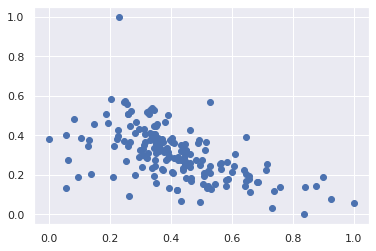

In [7]:
plt.scatter(sentiment_pos,sentiment_neg);

In [14]:
half = int(len(sentiment_pos) / 2)
bins = bins[:len(sentiment_pos)]

In [15]:
sentiment_neg_1 = sentiment_neg[:half]
sentiment_neg_2 = sentiment_neg[half:]

sentiment_pos_1 = sentiment_pos[:half]
sentiment_pos_2 = sentiment_pos[half:]

sentiment_score_1 = sentiment_score[:half]
sentiment_score_2 = sentiment_score[half:]

bins_1 = bins[:half]
bins_2 = bins[half:]

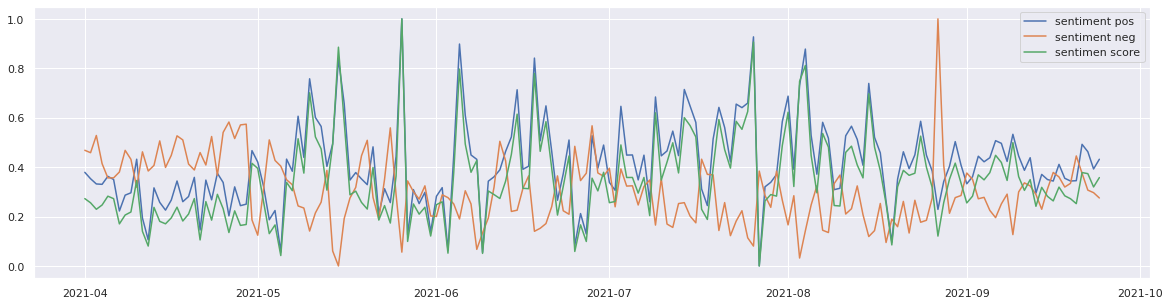

In [16]:
legend = ['sentiment pos', 'sentiment neg', 'sentimen score']
plt.figure(figsize=(20,5))
plt.plot(bins, sentiment_pos)
plt.plot(bins, sentiment_neg)
plt.plot(bins, sentiment_score)
plt.legend(legend);

### Find the extreme sentiment date

In [17]:
neg_date_1 = np.array(bins_1)[(sentiment_score_1<np.sort(sentiment_score_1)[int(0.15*len(sentiment_score_1))]) | (sentiment_neg_1>np.sort(sentiment_neg_1)[int(0.85*len(sentiment_neg_1))])]
super_neg_date_1 = np.array(bins_1)[(sentiment_score_1<np.sort(sentiment_score_1)[int(0.05*len(sentiment_score_1))]) | (sentiment_neg_1>np.sort(sentiment_neg_1)[int(0.95*len(sentiment_neg_1))])]
                                
pos_date_1 = np.array(bins_1)[(sentiment_score_1>np.sort(sentiment_score_1)[int(0.85*len(sentiment_score_1))]) | (sentiment_pos_1>np.sort(sentiment_pos_1)[int(0.85*len(sentiment_pos_1))])]
super_pos_date_1 = np.array(bins_1)[(sentiment_score_1>np.sort(sentiment_score_1)[int(0.95*len(sentiment_score_1))]) | (sentiment_pos_1>np.sort(sentiment_pos_1)[int(0.95*len(sentiment_pos_1))])]

In [18]:
neg_date_2 = np.array(bins_2)[(sentiment_score_2<np.sort(sentiment_score_2)[int(0.15*len(sentiment_score_2))]) | (sentiment_neg_2>np.sort(sentiment_neg_2)[int(0.85*len(sentiment_neg_2))])]
super_neg_date_2 = np.array(bins_2)[(sentiment_score_2<np.sort(sentiment_score_2)[int(0.05*len(sentiment_score_2))]) | (sentiment_neg_2>np.sort(sentiment_neg_2)[int(0.95*len(sentiment_neg_2))])]
                                
pos_date_2 = np.array(bins_2)[(sentiment_score_2>np.sort(sentiment_score_2)[int(0.85*len(sentiment_score_2))]) | (sentiment_pos_2>np.sort(sentiment_pos_2)[int(0.85*len(sentiment_pos_2))])]
super_pos_date_2 = np.array(bins_2)[(sentiment_score_2>np.sort(sentiment_score_2)[int(0.95*len(sentiment_score_2))]) | (sentiment_pos_2>np.sort(sentiment_pos_2)[int(0.95*len(sentiment_pos_2))])]

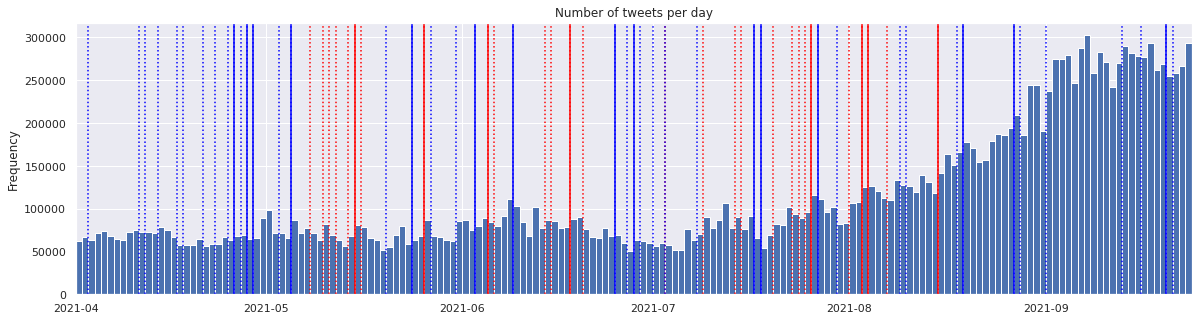

In [19]:
plt.figure(figsize=(20,5))

df['created_at'].plot.hist(bins = bins, xlim=(bins[0], bins[-1]), legend=False)
plt.title('Number of tweets per day')
for date in super_pos_date_1:
    plt.axvline(date, color = 'red')
for date in super_neg_date_1:
    plt.axvline(date, color = 'blue')
for date in pos_date_1:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_1:
    plt.axvline(date, color = 'blue',linestyle=':')

for date in super_pos_date_2:
    plt.axvline(date, color = 'red')
for date in super_neg_date_2:
    plt.axvline(date, color = 'blue')
for date in pos_date_2:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_2:
    plt.axvline(date, color = 'blue',linestyle=':')
plt.show()

### Map them on the trade volume distribution

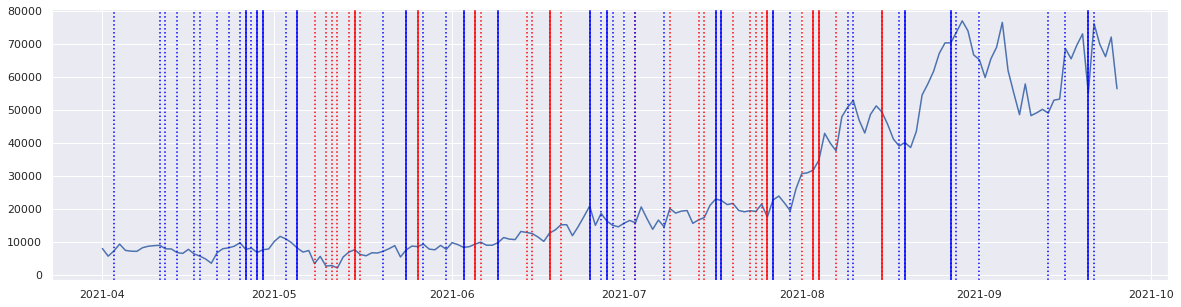

In [24]:
plt.figure(figsize=(20,5))
plt.plot(bins, list_trade[:len(bins)]);
for date in super_pos_date_1:
    plt.axvline(date, color = 'red')
for date in super_neg_date_1:
    plt.axvline(date, color = 'blue')
for date in pos_date_1:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_1:
    plt.axvline(date, color = 'blue',linestyle=':')

for date in super_pos_date_2:
    plt.axvline(date, color = 'red')
for date in super_neg_date_2:
    plt.axvline(date, color = 'blue')
for date in pos_date_2:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_2:
    plt.axvline(date, color = 'blue',linestyle=':')

In [ ]:
#sentiment_neg_trend = np.array(sentiment_neg[1:]) - np.array(sentiment_neg[:-1])
#sentiment_pos_trend = np.array(sentiment_pos[1:]) - np.array(sentiment_pos[:-1])
#sentiment_neg_trend = (sentiment_neg_trend>0)*1
#sentiment_pos_trend = (sentiment_pos_trend>0)*1

### Map them on Daily Average Price

In [25]:
transfers = dataset.load_dataframe('transfers')
transfers['date'] = pd.to_datetime(transfers['timestamp'], unit='s').dt.date
transfers['transaction_value_eth'] = transfers['transaction_value'] / 1e18

eth_to_usd = {}
with open(DATA_PATH+'ETH-USD.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, )
    for row in csv_reader:
        date = datetime.fromisoformat(row['Date']).date()
        price = (float(row['Open']) + float(row['Close'])) / 2  # average of opening and closing price
        eth_to_usd[date] = price

transfers['transaction_value_usd'] = transfers['date'].map(lambda d: eth_to_usd[d]) * transfers['transaction_value_eth']

In [26]:
aggregated_sum = transfers.groupby(['date']).sum()
aggregated_mean = transfers.groupby(['date']).mean()

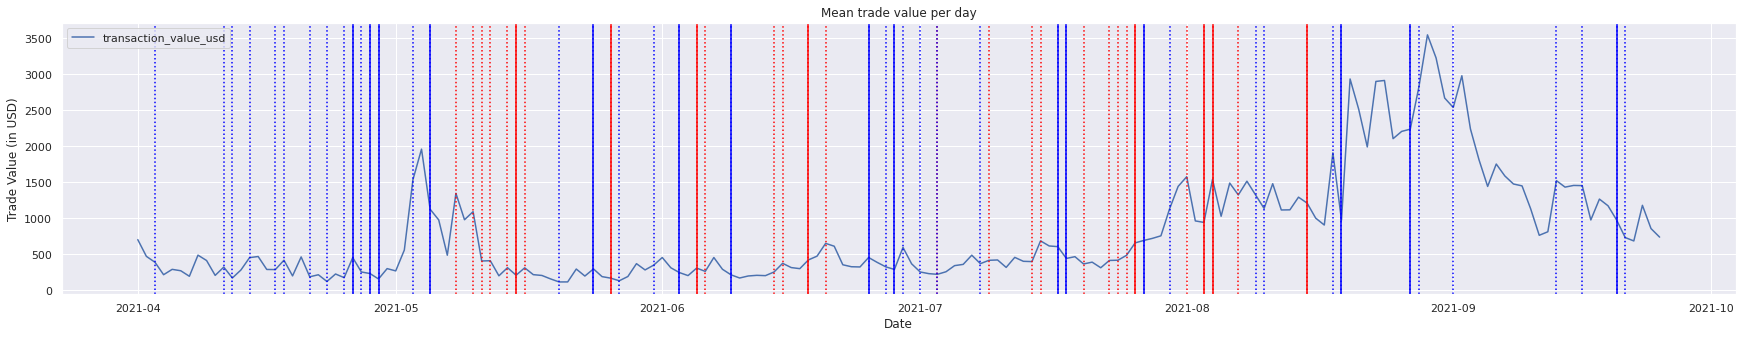

In [27]:
aggregated_mean.plot(y='transaction_value_usd', figsize=(30,5))
for date in super_pos_date_1:
    plt.axvline(date, color = 'red')
for date in super_neg_date_1:
    plt.axvline(date, color = 'blue')
for date in pos_date_1:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_1:
    plt.axvline(date, color = 'blue',linestyle=':')

for date in super_pos_date_2:
    plt.axvline(date, color = 'red')
for date in super_neg_date_2:
    plt.axvline(date, color = 'blue')
for date in pos_date_2:
    plt.axvline(date, color = 'red',linestyle=':')
for date in neg_date_2:
    plt.axvline(date, color = 'blue',linestyle=':')
plt.title('Mean trade value per day')
plt.xlabel('Date')
plt.ylabel('Trade Value (in USD)')
plt.show()

### Map on Hourly Average Price

In [28]:
transfers = dataset.load_dataframe('transfers')
transfers['date'] = pd.to_datetime(transfers['timestamp'], unit='s')
transfers['date'] = transfers['date'].apply(lambda x: str(x)[:13])

transfers['transaction_value_eth'] = transfers['transaction_value'] / 1e18

In [29]:
eth_to_usd = {}
with open(DATA_PATH+'ETH-USD.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, )
    for row in csv_reader:
        date = str(datetime.fromisoformat(row['Date']).date())
        price = (float(row['Open']) + float(row['Close'])) 
        eth_to_usd[date] = price

In [30]:
transfers['transaction_value_usd'] = transfers['date'].map(lambda d: eth_to_usd[d[:10]]) * transfers['transaction_value_eth']

In [31]:
aggregated_sum = transfers.groupby(['date']).sum()
aggregated_mean = transfers.groupby(['date']).mean()

In [32]:
aggregated_mean.index = pd.to_datetime(aggregated_mean.index, infer_datetime_format=True)  

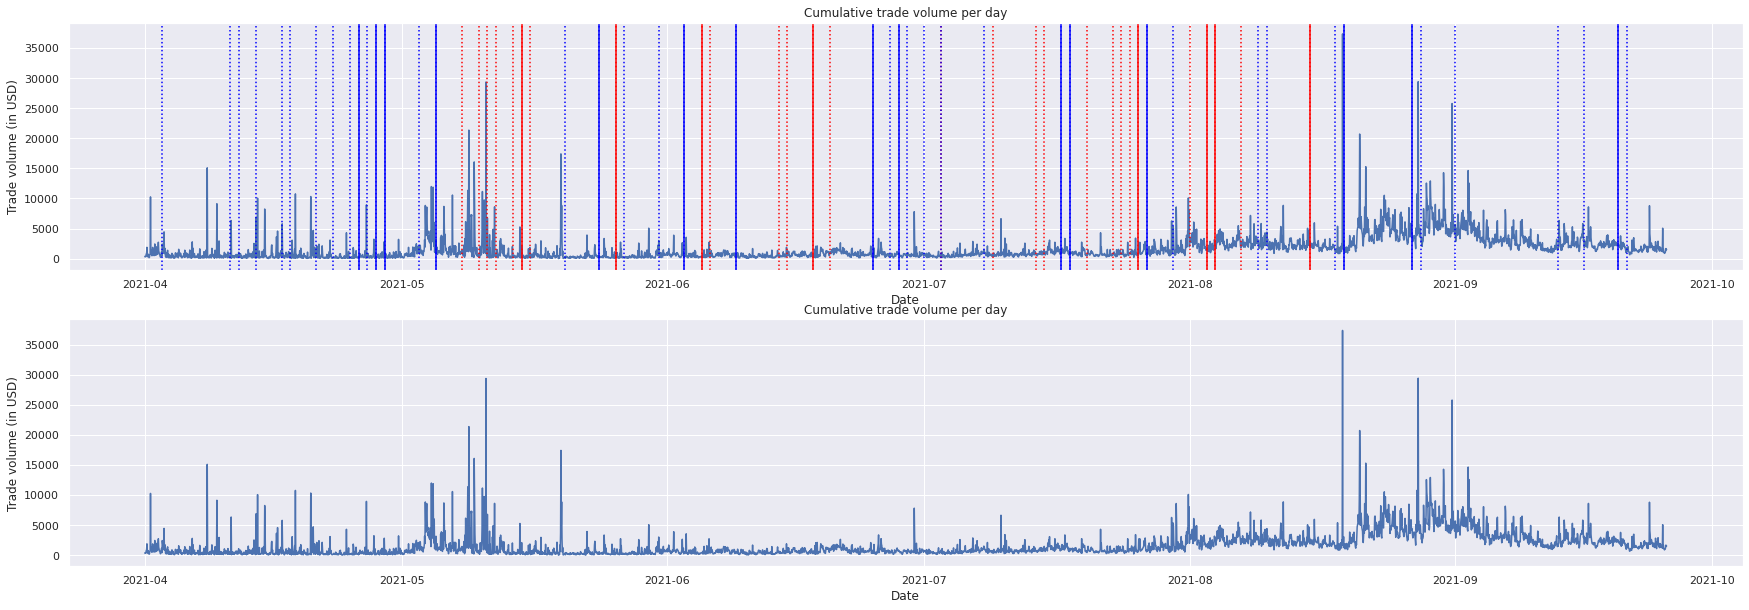

In [33]:
fig, axs = plt.subplots(2,1, figsize=(30,10))

axs[0].plot(list(aggregated_mean.index), aggregated_mean['transaction_value_usd'])
axs[0].set_title('Cumulative trade volume per day')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Trade volume (in USD)')

for date in super_pos_date_1:
    axs[0].axvline(date, color = 'red')
for date in super_neg_date_1:
    axs[0].axvline(date, color = 'blue')
for date in pos_date_1:
    axs[0].axvline(date, color = 'red',linestyle=':')
for date in neg_date_1:
    axs[0].axvline(date, color = 'blue',linestyle=':')

for date in super_pos_date_2:
    axs[0].axvline(date, color = 'red')
for date in super_neg_date_2:
    axs[0].axvline(date, color = 'blue')
for date in pos_date_2:
    axs[0].axvline(date, color = 'red',linestyle=':')
for date in neg_date_2:
    axs[0].axvline(date, color = 'blue',linestyle=':')

axs[1].plot(list(aggregated_mean.index), aggregated_mean['transaction_value_usd'])
axs[1].set_title('Cumulative trade volume per day')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Trade volume (in USD)')

plt.show()